In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import nltk
import pandas as pd
import ast
import re
import numpy as np

import string 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

import unidecode
import nltk.corpus
from gensim.models import Word2Vec

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import config
import torch
from transformers import BertTokenizer, BertModel

[nltk_data] Error loading wordnet: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df = pd.read_csv("/Users/ved/Desktop/Capstone/Dataset/Cleaned_Indian_Food_Dataset.csv")
df.head()

,TranslatedRecipeName,TranslatedIngredients,TotalTimeInMins,Cuisine,TranslatedInstructions,URL,Cleaned-Ingredients,image-url,Ingredient-count
0,Masala Karela Recipe,"1 tablespoon Red Chilli powder,3 tablespoon Gr...",45,Indian,"To begin making the Masala Karela Recipe,de-se...",https://www.archanaskitchen.com/masala-karela-...,"salt,amchur (dry mango powder),karela (bitter ...",https://www.archanaskitchen.com/images/archana...,10
1,Spicy Tomato Rice (Recipe),"2 teaspoon cashew - or peanuts, 1/2 Teaspoon ...",15,South Indian Recipes,"To make tomato puliogere, first cut the tomato...",https://www.archanaskitchen.com/spicy-tomato-r...,"tomato,salt,chickpea lentils,green chilli,rice...",https://www.archanaskitchen.com/images/archana...,12
2,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1 Onion - sliced,1 teaspoon White Urad Dal (Sp...",50,South Indian Recipes,"To begin making the Ragi Vermicelli Recipe, fi...",https://www.archanaskitchen.com/ragi-vermicell...,"salt,rice vermicelli noodles (thin),asafoetida...",https://www.archanaskitchen.com/images/archana...,12
3,Gongura Chicken Curry Recipe - Andhra Style Go...,"1/2 teaspoon Turmeric powder (Haldi),1 tablesp...",45,Andhra,To begin making Gongura Chicken Curry Recipe f...,https://www.archanaskitchen.com/gongura-chicke...,"tomato,salt,ginger,sorrel leaves (gongura),fen...",https://www.archanaskitchen.com/images/archana...,15
4,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"oil - as per use, 1 tablespoon coriander seed...",30,Andhra,"To make Andhra Style Alam Pachadi, first heat ...",https://www.archanaskitchen.com/andhra-style-a...,"tomato,salt,ginger,red chillies,curry,asafoeti...",https://www.archanaskitchen.com/images/archana...,12


In [12]:
df.rename(columns = {'Cleaned-Ingredients':'ingredients'}, inplace = True)
for i in range(len(df["ingredients"])):
    df["ingredients"][i]=re.sub("\(.*?\)","",df["ingredients"][i])
    df["ingredients"][i] = df["ingredients"][i].replace('(','').replace(')','')
    df["ingredients"][i] = df["ingredients"][i].split(',')

def ingredient_parser(ingredients):
    # measures and common words (already lemmatized)   
    measures = ['teaspoon', 't', 'tsp.', 'tablespoon', 'T', ...]
    words_to_remove = ['fresh', 'a', 'red', 'bunch', ...]
    # Turn ingredient list from string into a list 
    if isinstance(ingredients, list):
       pass
    else:
       ingredients = ast.literal_eval(ingredients)
    # We first get rid of all the punctuation
    remove_punctuations = str.maketrans('', '', string.punctuation)
    # initialize nltk's lemmatizer    
    lemmatizer = WordNetLemmatizer()
    ingred_list = []
    for each_item in ingredients:
        each_item.translate(remove_punctuations)
        # We split up with hyphens as well as spaces
        items = re.split(' |-', each_item)
        # Get rid of words containing non alphabet letters
        items = [word for word in items if word.isalpha()]
        # Turn everything to lowercase
        items = [word.lower() for word in items]
        # remove accents
        items = [unidecode.unidecode(word) for word in items]
        # Lemmatize words so we can compare words to measuring words
        items = [lemmatizer.lemmatize(word) for word in items]
        # get rid of stop words
        stop_words = set(nltk.corpus.stopwords.words('english'))
        items = [word for word in items if word not in stop_words]
        # Gets rid of measuring words/phrases, e.g. heaped teaspoon
        items = [word for word in items if word not in measures]
        # Get rid of common easy words
        items = [word for word in items if word not in words_to_remove]
        if items:
           ingred_list.append(' '.join(items))
    return ingred_list
df['parsed'] = df.ingredients.apply(ingredient_parser)

/var/folders/1m/v10vjxqd235fn30s91s6nnx40000gn/T/ipykernel_5338/1185335505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ingredients"][i]=re.sub("\(.*?\)","",df["ingredients"][i])
/var/folders/1m/v10vjxqd235fn30s91s6nnx40000gn/T/ipykernel_5338/1185335505.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ingredients"][i] = df["ingredients"][i].replace('(','').replace(')','')
/var/folders/1m/v10vjxqd235fn30s91s6nnx40000gn/T/ipykernel_5338/1185335505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [13]:
ingredients = df.parsed.explode().unique()

In [15]:
recipeIngredients = df.ingredients.explode()
countIngredients = recipeIngredients.value_counts().reset_index()
#dfCountIngredients = countIngredients.to_frame()
countIngredients = countIngredients.rename(columns = {"index":"Ingredient", "ingredients":"weight"})

In [16]:
countIngredients 

,Ingredient,weight
0,salt,4712
1,onion,2154
2,sunflower oil,2073
3,turmeric powder,2030
4,red chilli powder,1613
...,...,...
4715,ghee roasting the gulachi poli,1
4716,arhar dal hour,1
4717,sesame oil regular oil,1
4718,rabodi,1


In [20]:
#for ingre in countIngredients.Ingredient[:1]:
    #ingreRela[ingre] = [data.ingredients.apply(lambda x: ingre in x)]
    #mask = data.ingredients.apply(lambda x: ingre in x)
                       
#len(data.ingredients[mask].explode().unique())
def getRelationships(data, countIngredients):
    masks = []
    ingredientsRelations = []
    for ingre in countIngredients.Ingredient:
        masks.append(data.ingredients.apply(lambda x: ingre in x))
    for mask in masks:
        ingredientsRelations.append(data.ingredients[mask].explode().unique())
    countIngredients ["Relationships"] = ingredientsRelations
    return countIngredients
    
dfRelationship = getRelationships(df,countIngredients)


In [21]:
dfRelationship.tail()

,Ingredient,weight,Relationships
4715,ghee roasting the gulachi poli,1,"[salt, wheat flour, nutmeg powder, milk, jagge..."
4716,arhar dal hour,1,"[tomato, salt, cumin powder , tamarind water, ..."
4717,sesame oil regular oil,1,"[tomato, salt, arhar dal , sesame oil regular..."
4718,rabodi,1,"[turmeric powder, salt, red chilli powder, wat..."
4719,condensed milk khoya,1,"[ghee, milk, saffron strands, sugar, cardamom ..."


In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# well I lied after looking in the nx docs we first have to unpack our list of relationships

dfRelationship.explode("Relationships")

## that will make our dataset kinda big so I will remove the salt column (I would prefere removing all spices)
    ## but for that I would need a dataset to crossmatch
#edgedf = dfRelationship[(dfRelationship.weight < 100)&(dfRelationship.weight > 50)].explode("Relationships")
#edgedf = dfRelationship[:20].explode("Relationships")
edgedf = dfRelationship[dfRelationship.Ingredient == "cheese"].explode("Relationships")
edgedf = edgedf[edgedf.Ingredient != edgedf.Relationships] ## remove edges from and to same node (salt --> salt)
edgedf

,Ingredient,weight,Relationships
94,cheese,127,salt
94,cheese,127,burger buns
94,cheese,127,potato pressure
94,cheese,127,tomato
94,cheese,127,soy granules
...,...,...,...
94,cheese,127,kasuri methi
94,cheese,127,capsicum
94,cheese,127,coriander leaves parsley herb choice
94,cheese,127,ginger paste


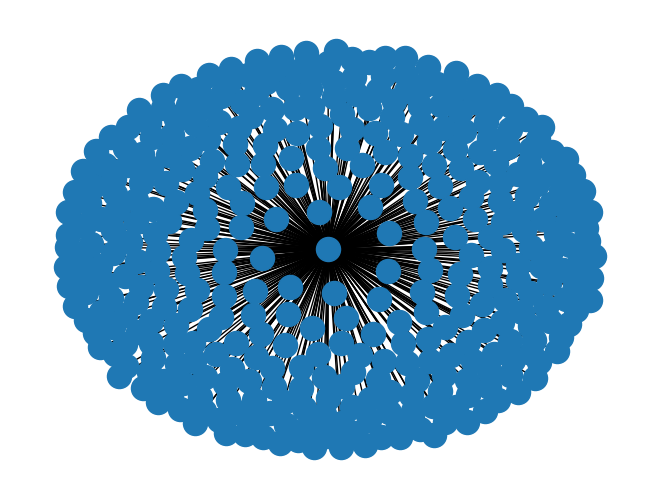

In [25]:
G = nx.from_pandas_edgelist(edgedf,"Ingredient","Relationships")
nx.draw(G,with_labels=False)
plt.show()

In [33]:
from pyvis.network import Network
net = Network(notebook=True, cdn_resources='remote')
net = Network(notebook=True)
net.from_nx(G)
net.show("cheese.html")

cheese.html
